In [96]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from scipy.special import expit

## Generating synthetic data

In [123]:
def generate_features(n):
    # Dimension of features
    p = 25
    
    # Mean for each feature
    mean = np.zeros(p)
    
    # Covariance matrix
    cov = np.asmatrix(np.diag(10 / np.array(range(1, p+1)) ** 2))
    
    # Generate mulivariate normal data
    X = np.random.multivariate_normal(mean, cov, n)
    
    return X

def generate_distribution_params():
    # Dimension of features
    p = 25
    
    # Mean for the linear weight vector
    mean = np.zeros(p)
    
    # Covariance matrix for entries in the weight vector
    cov = np.eye(p)
    
    # Generate weight vectors
    w1 = np.random.multivariate_normal(mean, cov)
    w2 = np.random.multivariate_normal(mean, cov)
    
    # Generate bias terms
    b1 = np.random.normal(0, 1)
    b2 = np.random.normal(0, 1)
    
    return (w1, b1), (w2, b2)

def generate_labels(X):
    # Generate the parameters of the label-generating distribution
    (w1, b1), (w2, b2) = generate_distribution_params()
    
    # Obtain minimum of two linear scores
    scores1 = X * np.asmatrix(w1).T + b1
    scores2 = X * np.asmatrix(w2).T + b2
    min_scores = np.min([scores1, scores2], axis=0)
    
    # Apply sigmoid function
    prob = expit(min_scores)
    
    # Generate Bernoulli random labels
    labels = np.random.binomial(1, prob)
    
    return labels

def generate_data(n):
    # Generate features
    X = generate_features(n)
    
    # Generate labels
    y = generate_labels(X)
    
    return X, y

In [412]:
n = 50000
X, y = generate_data(n)
np.sum(y)

19763

In [413]:
# Store a sequence of random points to be used in each run
indices = np.random.randint(0, n, 200_000)
randX = X[indices]
randY = y[indices]

## Implementing logistic regression

In [291]:
def log_likelihood(X, w, y):
    # Compute softmax predictions
    scores = np.dot(X, w)
    prob = expit(scores)
    
    # Log likelihood = 1/N * sum(log p(y_i | x_i))
    log_lik = (y.T * np.log(prob) + (1 - y).T * np.log(1 - prob)) / X.shape[0]
    
    return np.mean(log_lik)

def objective(X, w, y):
    log_loss = -log_likelihood(X, w, y)
    l2_norm = np.linalg.norm(w)
    return log_loss, l2_norm

def gradient(X, w, y):
    # Compute softmax predictions
    scores = np.dot(X, w)
    prob = np.asmatrix(expit(scores))
    
    # Compute the gradient of the log loss
    grad = np.dot(np.transpose(X), prob - y) / X.shape[0]
    
    # Compute the gradient of the l2 norm
    l2_grad = 2 * w
    
    return grad, l2_grad

## Implementing SGD

In [471]:
def minibatch_sgd(X, y, lmbda=0, eta=1e-3):
    
    M = 100  # Number of machines in each round
    K = 10   # Number of stochastic gradients to calculate on each machine
    R = 50   # Number of rounds
    
    w0 = np.asmatrix(np.zeros(X.shape[1])).T
    
    w = w0
    next_idx = 0
    log_losses = []
    l2_norms = []
    
    log_loss, l2_norm = objective(X, w, y)
    log_losses.append(log_loss)
    l2_norms.append(l2_norm)
    
    for r in range(R):
        if r % (R / 10) == 0:
            #print(f'Starting round {r}')
            pass
        
        X_batch = X[next_idx:next_idx + K * M]
        y_batch = y[next_idx:next_idx + K * M]
        next_idx += K * M
        
        grad, l2_grad = gradient(X_batch, w, y_batch)
        w = w - eta * K * (grad + lmbda / 2 * l2_grad)
        
        log_loss, l2_norm = objective(X, w, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
        
    return log_losses, l2_norms, w

In [384]:
class DataSource:
    """
    Acts like a "button" for random sample data. Reads in the entire sample dataset and stores it locally.
    Then returns data randomly to each machine to prevent re-use of the same data.
    """
    def __init__(self):
        self._X = randX
        self._Y = randY
        self._num_used = 0

    def generate_observations(self, count):
        X = self._X[self._num_used:self._num_used+count]
        Y = self._Y[self._num_used:self._num_used+count]
        self._num_used += count
        return (X, Y)

class Machine:
    """
    Represents an invididual machine in the network. We will instantiate it with some data,
    ask it to perform some gradient updates and return the results, then forget about this
    machine and the data that was given to it.
    """
    def __init__(self, source, data_count):
        X_local, Y_local = source.generate_observations(data_count)
        self._X = X_local # Locally stored predictor data
        self._Y = Y_local # Locally stored responder data
        self._m = data_count

    def execute_inner_sgd(self, eta_inner, w_cur):
        w = np.copy(w_cur)
        grads = []
        for i in range(self._m):
            # Execute the local gradient step:
            grad, _ = gradient(self._X[ [i] ], w, self._Y[ [i] ])
            w = w - eta_inner * grad
            
            grads.append(grad)
        
        # Return the sum of observed gradients
        return np.sum(grads, axis=0)

    def execute_pipelined_DSVRG(self, w_cur, w_prev, g_prev, eta):
        # Iterate m steps of variance-reduced SGD on the local data
        w = np.copy(w_cur)
        for i in range(self._m):
            # Compute the gradient adjustment for the current iterate:
            # g_(t-1) - nabla f_(k,i)(w_(t-1))
            grad_adjustment = g_prev - gradient(self._X[ [i] ], w_prev, self._Y[ [i] ])[0]
            
            # Execute the variace reduced gradient step:
            w = w - eta * (gradient(self._X[ [i] ], w, self._Y[ [i] ])[0] + grad_adjustment)
            
            # TODO: possibly add gamma shrinkage term
        
        # Compute the local gradient at the iterate where we started the round
        g_local, _ = gradient(self._X, w_cur, self._Y)
        return w, g_local
        

In [387]:
def experiment_method_1(X, y, R=100, M=10, k=5, eta_inner=0.001, eta_outer=0.001):
    """
    Runs an inner/outer SGD and returns the log losses each round, parameter norms each round,
    and the final parameter value.
    """
    
    # Create a DataSource class to avoid repeated use of data
    source = DataSource()
    
    # Check that we have enough data for the desired experiment
    if R * M * k > randX.shape[0]:
        print('Not enough training data')
        return
    
    # Initialize to zero
    w0 = np.asmatrix(np.zeros(X.shape[1])).T
    ws = [w0]
    
    log_losses = []
    l2_norms = []
    
    log_loss, l2_norm = objective(X, w0, y)
    log_losses.append(log_loss)
    l2_norms.append(l2_norm)
    
    # Execute R outer iterations
    for _ in range(R):
        w_cur = ws[-1]
        
        # Generate M random machines to perform the Local SGD steps
        inner_results = [
            Machine(source, data_count=k).execute_inner_sgd(eta_inner, w_cur)
        for _ in range(M)]
        
        # Perform the outer gradient step
        w_next = w_cur - eta_outer/M * np.sum(inner_results, axis=0)
        ws.append(w_next)
        
        # Record progress on the objective
        log_loss, l2_norm = objective(X, w_next, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
    
    return log_losses, l2_norms, ws[-1]

Running a generic minibatch SGD to check the logistic regression implementation.

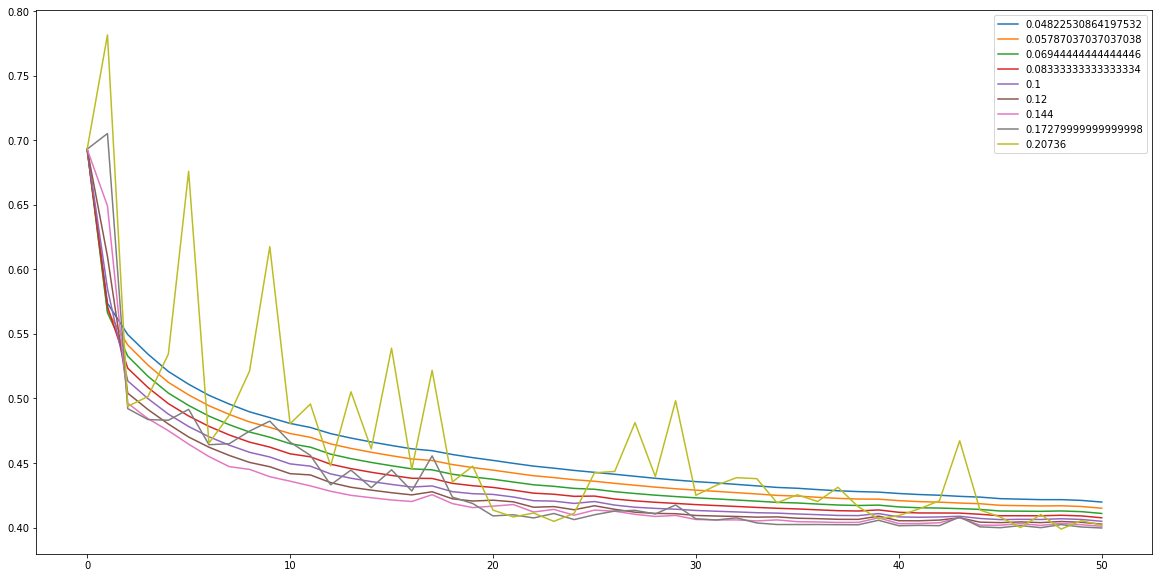

In [473]:
pows = np.arange(-4,5)
base = 1.2
coef = .1
grid = coef * base ** pows

plt.figure(figsize=(20,10))

for eta in grid:
    log_losses, l2_norms, w = minibatch_sgd(X, y, eta=eta)
    plt.plot(log_losses, label=eta)

plt.legend()
plt.show()

## Testing Local SGD

0.39810052037464205


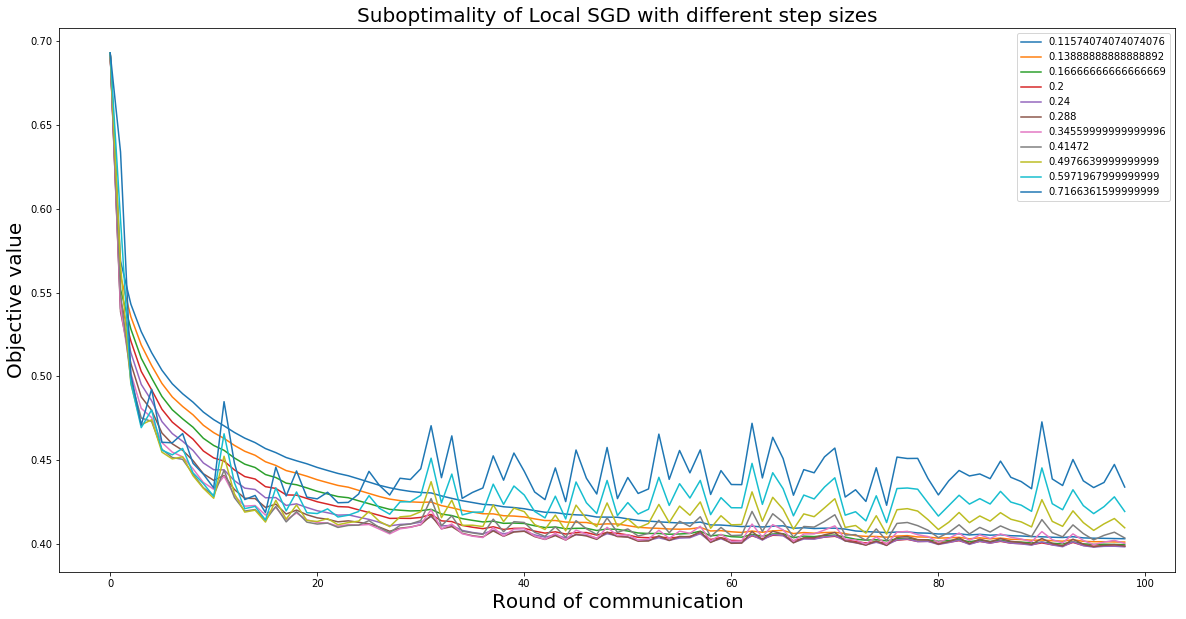

In [456]:
# Create a log-scale grid of step sizes to try
pows = np.arange(-3,8)
base = 1.2
coef = .2
grid = coef * base ** pows

plt.figure(figsize=(20,10))

best = np.inf

# Test performance across grid
for eta in grid:
    log_losses, l2_norms, w = experiment_method_1(X, y, R=100, M=200, k=5, eta_inner=eta, eta_outer=eta)
    plt.plot(log_losses, label=eta)
    
    best = min(best, log_losses[-1])

print(best)

plt.legend()
plt.title('Suboptimality of Local SGD with different step sizes', fontsize=20)
plt.xlabel('Round of communication', fontsize=20)
plt.ylabel('Objective value', fontsize=20)
plt.show()

## Testing Minibatch SGD

/Users/geoffreywest/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


0.3964947742873248


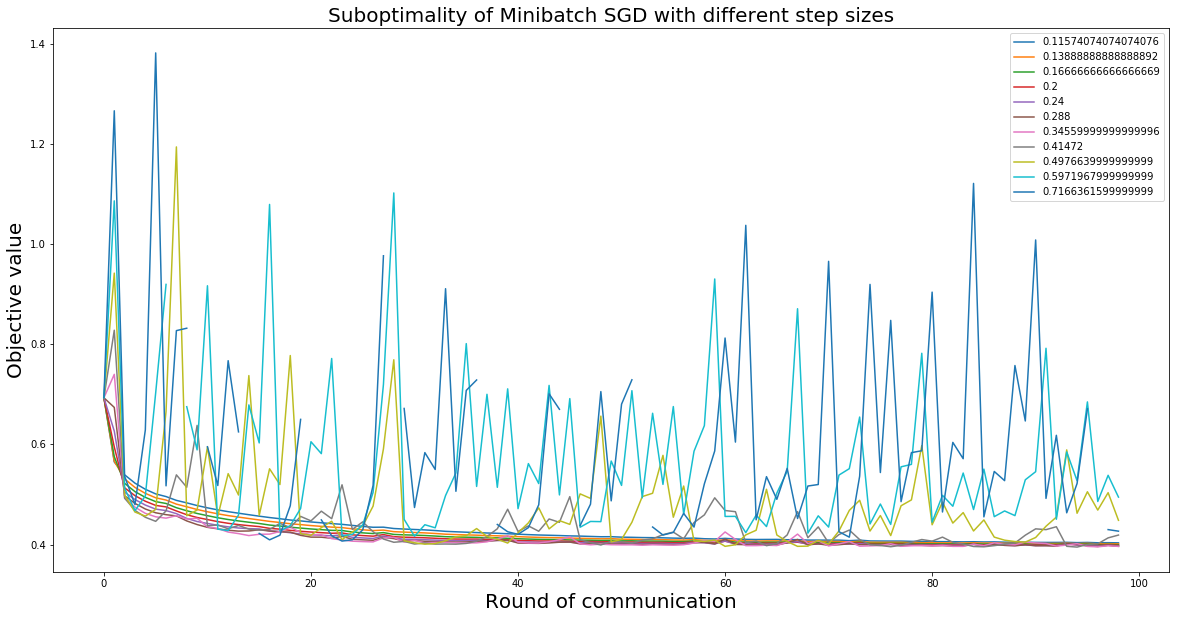

In [457]:
# Create a log-scale grid of step sizes to try
pows = np.arange(-3,8)
base = 1.2
coef = .2
grid = coef * base ** pows

plt.figure(figsize=(20,10))

best = np.inf

# Test performance across grid
for eta in grid:
    log_losses, l2_norms, w = experiment_method_1(X, y, R=100, M=200, k=5, eta_inner=0, eta_outer=eta)
    plt.plot(log_losses, label=eta)
    
    best = min(best, log_losses[-1])

print(best)

plt.legend()
plt.title('Suboptimality of Minibatch SGD with different step sizes', fontsize=20)
plt.xlabel('Round of communication', fontsize=20)
plt.ylabel('Objective value', fontsize=20)
plt.show()

## Testing 1/2 inner step size

0.39556970834508626


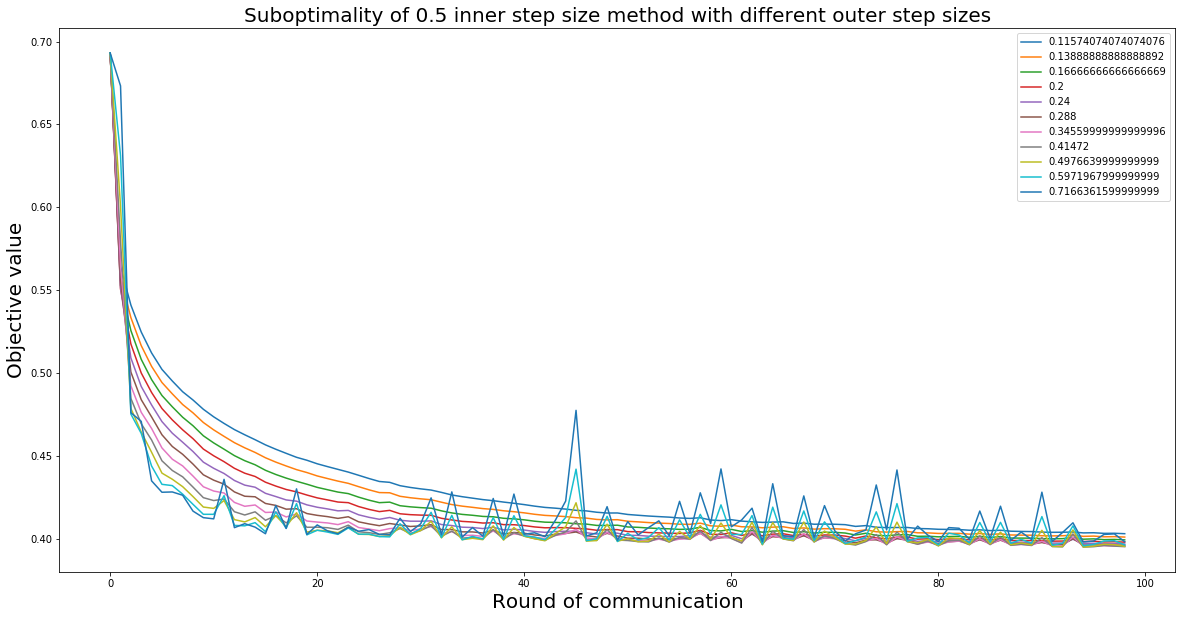

In [458]:
# Create a log-scale grid of step sizes to try
pows = np.arange(-3,8)
base = 1.2
coef = .2
grid = coef * base ** pows

plt.figure(figsize=(20,10))

best = np.inf

# Test performance across grid
for eta in grid:
    log_losses, l2_norms, w = experiment_method_1(X, y, R=98, M=200, k=5, eta_inner=.5*eta, eta_outer=eta)
    plt.plot(log_losses, label=eta)
    
    best = min(best, log_losses[-1])

print(best)

plt.legend()
plt.title('Suboptimality of 0.5 inner step size method with different outer step sizes', fontsize=20)
plt.xlabel('Round of communication', fontsize=20)
plt.ylabel('Objective value', fontsize=20)
plt.show()

## Hypothetical scenario giving high variance for minibatch SGD

In [444]:
def relu(xs):
    return np.max([xs, np.zeros(xs.shape[0])], axis=0)

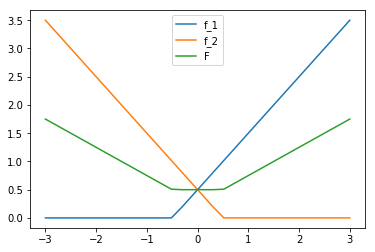

In [461]:
xs = np.linspace(-3,3,30)
plt.figure()
plt.plot(xs, relu(xs + .5), label='f_1')
plt.plot(xs, relu(-xs + .5), label='f_2')
plt.plot(xs, 0.5 * (relu(xs + .5) + relu(-xs + .5)), label='F')
plt.legend()
plt.show()